# Analysis Code for 4-Point Correlator

## General parameters and functions


In [1]:
%pip install numpy scipy iminuit matplotlib scienceplots

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
from matplotlib import ticker
import scienceplots

### Lattice setup

- PACS-CS Lattice QCD gauge ensemble:  
  [RC32x64_B1900Kud01378100Ks01364000C1715](https://www.jldg.org/ildg-data/PACSCSconfig.html#ENSEMBLE) _(all 5 series in the #6 ensemble)_  
  _Ref: [Aoki_PhysRevD.79.034503](/ccbar/pdf/Aoki_PhysRevD.79.034503.pdf)_

- Gauge configurations
  - $2 + 1$ flavor dynamical LQCD configurations on $32^3\times64$ lattice
    - RG improved Iwasaki gauge action ($\beta = 1.90$)
    - O(a)-improved Wilson quark action ($\kappa_{ud}=0.1378100$, $C_{\rm SW}=1.715$)
  - Pion Mass: $155.7\ \text{MeV}$ _(Almost the physical pion mass)_
  - Spatial size: $L = 2.902 42\ \text{fm}$ ($a = 0.0907(13)\ \text{fm}$)
  - Lattice cutoff: $a^{-1} ∼ 2.1753\ \text{GeV}$

- Charm quark is introduced by the quenched approximation by using the relativistic heavy quark action  
  _Ref: [Namekawa_PhysRevD.84.074505](/ccbar/pdf/Namekawa_PhysRevD.84.074505.pdf)_

- **Coulomb** and **Landau** gauge fixing

- **Wall source** and **point sink** for quark propagators

- Number of source points: **64**


In [15]:
xyz_size = 32
t_size = 64
a = 0.090713
a_invrs = 2.1753

t_half = int(t_size / 2)
xyz_cube = int(xyz_size**3)

### Paths, file names and more


In [16]:
droot = "/Volumes/X6/data/ccbar"

gfix = ["gfix_C", "gfix_L"]
gauge = ["Coulomb", "Landau"]
chan = ["ps", "v"]
binID = ["BIN" + f"{i:02}" for i in range(1, 19)]

### Customed functions

In [5]:
# cart2sphr (python version)
def cart2sphr_py(data):
    reshdata = data.reshape(-1, 2)
    datatmp = []
    for x in range(int(xyz_size / 2 + 1)):
        for y in range(x, int(xyz_size / 2 + 1)):
            for z in range(y, int(xyz_size / 2 + 1)):
                distance = (x**2 + y**2 + z**2) ** 0.5
                dxyz = reshdata[x + xyz_size * (y + xyz_size * z)]
                datatmp.append(np.array([distance, dxyz[0], dxyz[1]]))

    sphrdata = np.array(datatmp)
    sorted_indices = np.argsort(sphrdata[:, 0])
    sphrsorted = sphrdata[sorted_indices]
    return np.array(sphrsorted)


# 4ptcorr plot
def corrPlot4pt(data):
    fig, ax = plt.subplots()

    ax.scatter(
        data[:, 0] * a,
        data[:, 1] / data[0, 1],
        label=r"$t/a=29$",
        marker=".",
    )

    ax.legend()
    ax.set_xlabel(r"$r\ [{\rm fm}]$")
    ax.set_xlim(0, 1.4)
    ax.set_ylabel(r"$\tilde{C}(\mathbf{r},t)=C(\mathbf{r},t)/C(0,t)$")
    ax.set_ylim(-0.05, 1)

    plt.plot()
    plt.show()
    plt.close()

## Preparation

### Time reversal

Calculate $C_{\text{ave}}(n_t) = [C(n_t) + C(N_t - n_t)]/2$


In [6]:
for ig in range(2):
    ofpath = f"{droot}/{gfix[ig]}/4pt/trev"
    os.system(f"rm -rf {ofpath}")  # clear data
    os.makedirs(ofpath, exist_ok=True)  # make directory for output files
    for ich in range(2):
        for it in range(t_half):
            t1 = f"{it:+03}"
            t2 = f"{(t_size - it)%t_size:+03}"
            for ibin in range(18):
                ifname_t1 = f"{droot}/{gfix[ig]}/4pt/binned/4pt.{chan[ich]}.{t1}.{gfix[ig]}.{binID[ibin]}"
                ifname_t2 = f"{droot}/{gfix[ig]}/4pt/binned/4pt.{chan[ich]}.{t2}.{gfix[ig]}.{binID[ibin]}"
                ofname = f"{droot}/{gfix[ig]}/4pt/trev/{chan[ich]}.{t1}.{gfix[ig]}.{binID[ibin]}"
                assert os.path.exists(ifname_t1)
                assert os.path.exists(ifname_t2)

                os.system(f"bin/mean -l {xyz_cube} -o {ofname} {ifname_t1} {ifname_t2}")

            print(f"got [C({t1}) + C({t2})]/2 ({gauge[ig]}, {chan[ich]})")

got [C(+00) + C(+00)]/2 (Coulomb, ps)
got [C(+01) + C(+63)]/2 (Coulomb, ps)
got [C(+02) + C(+62)]/2 (Coulomb, ps)
got [C(+03) + C(+61)]/2 (Coulomb, ps)
got [C(+04) + C(+60)]/2 (Coulomb, ps)
got [C(+05) + C(+59)]/2 (Coulomb, ps)
got [C(+06) + C(+58)]/2 (Coulomb, ps)
got [C(+07) + C(+57)]/2 (Coulomb, ps)
got [C(+08) + C(+56)]/2 (Coulomb, ps)
got [C(+09) + C(+55)]/2 (Coulomb, ps)
got [C(+10) + C(+54)]/2 (Coulomb, ps)
got [C(+11) + C(+53)]/2 (Coulomb, ps)
got [C(+12) + C(+52)]/2 (Coulomb, ps)
got [C(+13) + C(+51)]/2 (Coulomb, ps)
got [C(+14) + C(+50)]/2 (Coulomb, ps)
got [C(+15) + C(+49)]/2 (Coulomb, ps)
got [C(+16) + C(+48)]/2 (Coulomb, ps)
got [C(+17) + C(+47)]/2 (Coulomb, ps)
got [C(+18) + C(+46)]/2 (Coulomb, ps)
got [C(+19) + C(+45)]/2 (Coulomb, ps)
got [C(+20) + C(+44)]/2 (Coulomb, ps)
got [C(+21) + C(+43)]/2 (Coulomb, ps)
got [C(+22) + C(+42)]/2 (Coulomb, ps)
got [C(+23) + C(+41)]/2 (Coulomb, ps)
got [C(+24) + C(+40)]/2 (Coulomb, ps)
got [C(+25) + C(+39)]/2 (Coulomb, ps)
got [C(+26) 

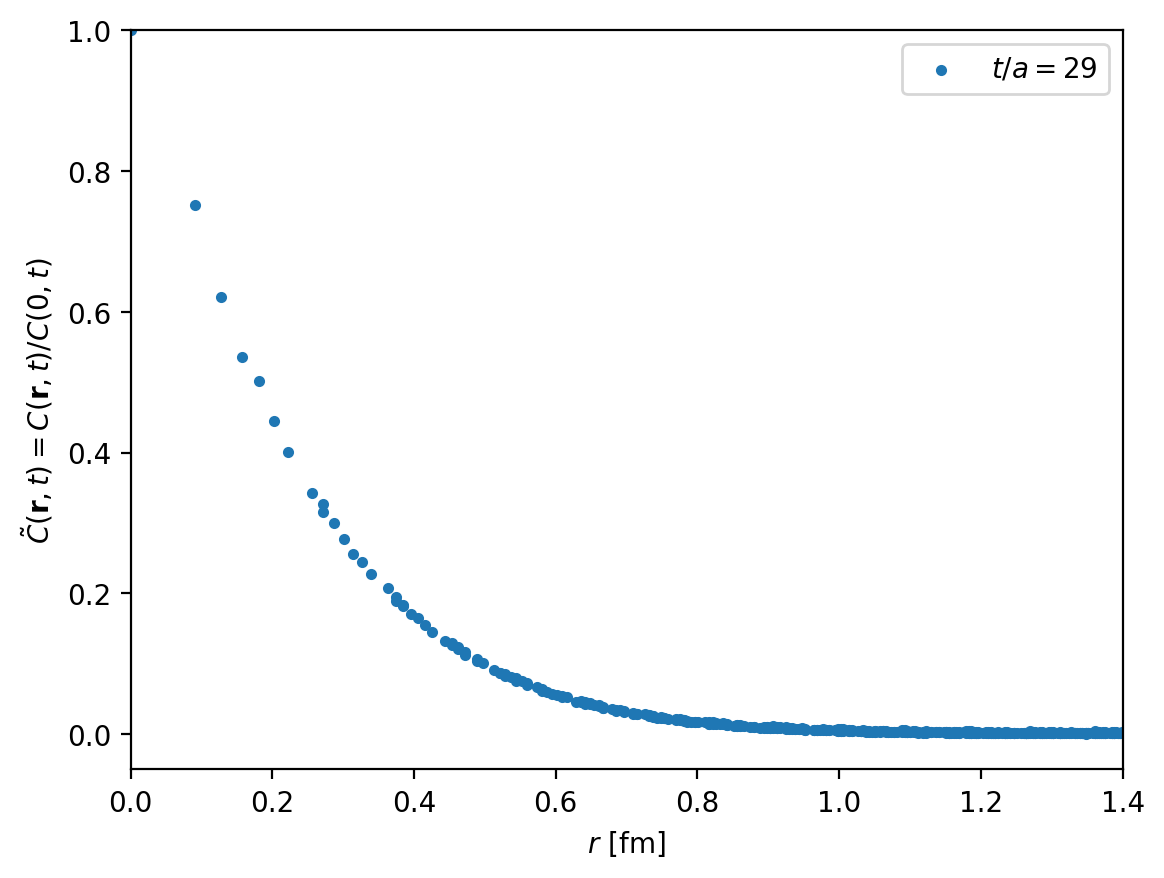

In [7]:
# result check
rawdata = np.fromfile(f"{droot}/{gfix[0]}/4pt/trev/{chan[0]}.+29.{gfix[0]}.{binID[0]}")
assert len(rawdata) == xyz_cube * 2
sphrdata = cart2sphr_py(rawdata)
corrPlot4pt(sphrdata)

We simply denote $C_{\text{ave}}(n_t)$ as $C(n_t)$ from below


### $A_1^+$ projection

$$
\phi(r)=\frac{1}{48}\sum_{g\in O_h}\phi(g^{-1}(\mathbf{x}-\mathbf{y}))
$$

In [8]:
for ig in range(2):
    ifpath = f"{droot}/{gfix[ig]}/4pt/trev"
    ofpath = f"{droot}/{gfix[ig]}/4pt/a1plus"
    os.system(f"rm -rf {ofpath}")  # clear data
    os.makedirs(ofpath, exist_ok=True)  # make directory for output files

    os.system(f"bin/a1plus -n {xyz_size} -d {ofpath} {ifpath}/*")

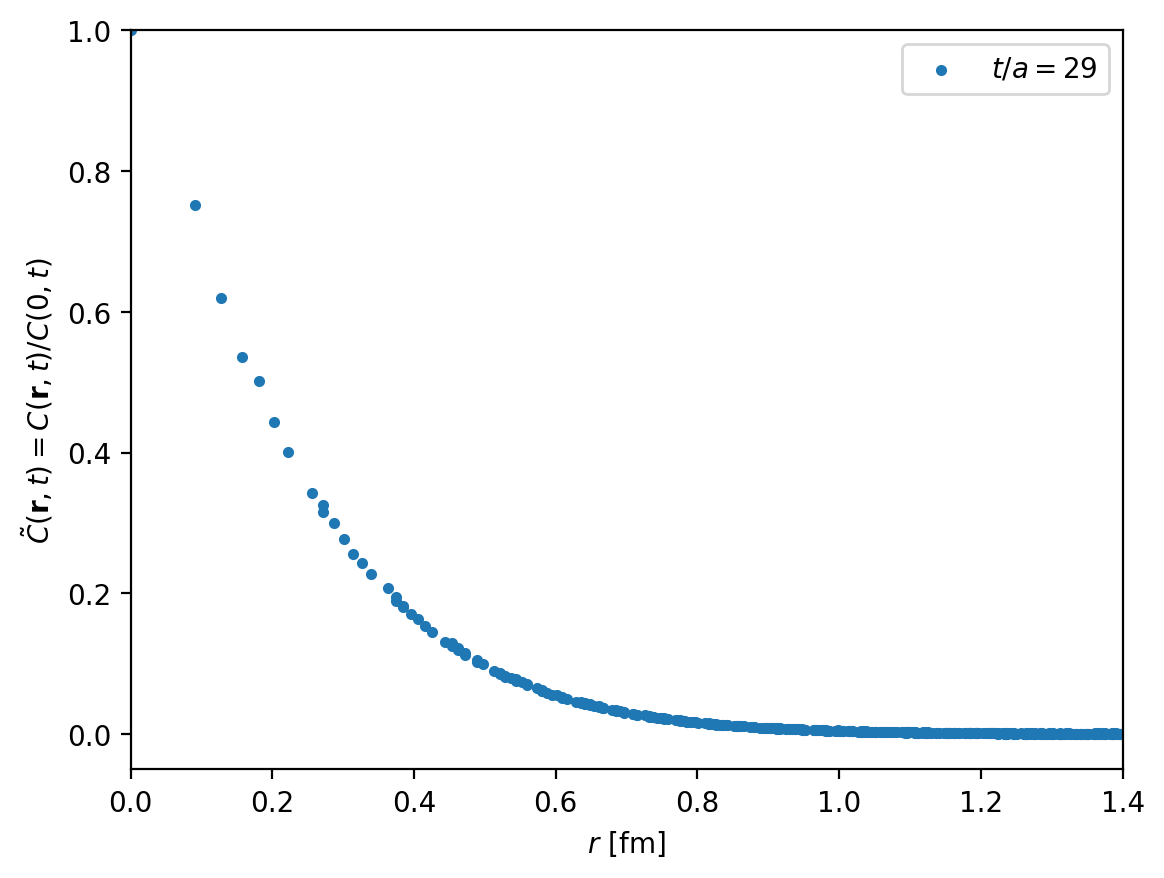

In [9]:
# result check
rawdata = np.fromfile(f"{droot}/{gfix[0]}/4pt/a1plus/{chan[0]}.+29.{gfix[0]}.{binID[0]}")
assert len(rawdata) == xyz_cube * 2
sphrdata = cart2sphr_py(rawdata)
corrPlot4pt(sphrdata)

### Jackknife resampling

In [10]:
for ig in range(2):
    ifpath = f"{droot}/{gfix[ig]}/4pt/a1plus"
    ofpath = f"{droot}/{gfix[ig]}/4pt/jksamp"
    os.system(f"rm -rf {ofpath}")  # clear data
    os.makedirs(ofpath, exist_ok=True)  # make directory for output files
    for ich in range(2):
        for it in range(t_half):
            t=f"{it:+03}"
            os.system(f"bin/jre -l {xyz_cube} -d {ofpath} {ifpath}/{chan[ich]}.{t}.*")

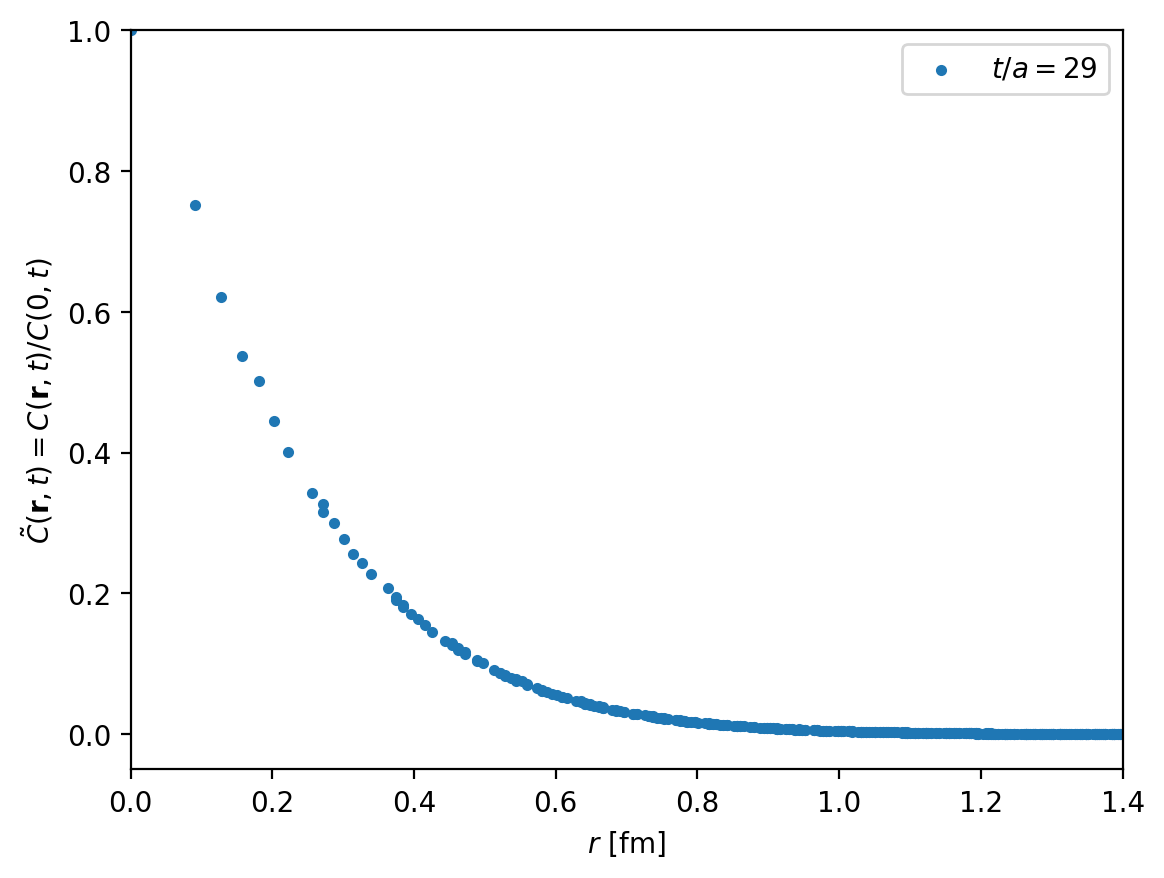

In [11]:
# result check
rawdata = np.fromfile(f"{droot}/{gfix[0]}/4pt/jksamp/{chan[0]}.+29.{gfix[0]}.{binID[0]}")
assert len(rawdata) == xyz_cube * 2
sphrdata = cart2sphr_py(rawdata)
corrPlot4pt(sphrdata)

## Correlator


## Pre-potential


In [12]:
# main part
for ig in range(2):
    ifpath = f"{droot}/{gfix[ig]}/4pt/jksamp"
    ofpath = f"{droot}/{gfix[ig]}/4pt/prev"
    os.system(f"rm -rf {ofpath}")  # clear data
    os.makedirs(ofpath, exist_ok=True)  # make directory for output files

    os.system(f"bin/prev -n {xyz_size} -d {ofpath} {ifpath}/*")

In [13]:
# jackknife average
for ig in range(2):
    result_path = f"result/{gauge[ig]}/prev"
    os.system(f"rm -rf {result_path}")  # clear data
    os.makedirs(result_path, exist_ok=True)  # make directory for output files
    for it in range(t_half):
        t = f"{it:+03}"
        for ich in range(2):
            iflist = f"{droot}/{gfix[ig]}/4pt/prev/{chan[ich]}.{t}.{gfix[ig]}.*"
            ofname = f"{result_path}/{chan[ich]}.{t}"

            iftest = iflist[:-1] + binID[0]
            assert os.path.exists(iftest)

            os.system(f"bin/mean -l {xyz_cube} -o {ofname} -jc {iflist}")
    
    

### Figure

In [14]:
# Convert all data to spherical coordinate
os.system(f"bin/cart2sphr -n {xyz_size} -d {result_path} -p sphr -s txt {result_path}/*")

0

#### Read data

In [ ]:
ps_c, v_c, ps_l, v_l = [[] for _ in range(4)]
for it in range(32):
    t = f"{it:+03}"
    ps_c.append(np.loadtxt(f"result/Coulomb/prev/sphr.ps.{t}.txt"))
    v_c.append(np.loadtxt(f"result/Coulomb/prev/sphr.v.{t}.txt"))
    ps_l.append(np.loadtxt(f"result/Landau/prev/sphr.ps.{t}.txt"))
    v_l.append(np.loadtxt(f"result/Landau/prev/sphr.v.{t}.txt"))

#### All time slices in one fig

##### set style

In [ ]:
# plt.style.use(["science", "nature"])
plt.style.use("default")

errbar_plot_style = {
    "fmt": ".",
    "markersize": 3,
    "markeredgewidth": 0.4,
    "linewidth": 0.25,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 4,
    "handletextpad": 0,
    "labelspacing": 0.3,
}

##### PS - Coulomb

In [ ]:
fig, ax = plt.subplots()

trange = np.append(np.array([0]), np.arange(4, 30, 5))

for i in trange:
    ax.errorbar(
        ps_c[i][:, 0],
        ps_c[i][:, 1],
        ps_c[i][:, 2],
        label=r"$n_t=$" + str(i).rjust(2, "0"),
        **errbar_plot_style
    )

ax.legend(**legend_style)

ax.set_xlabel(r"$n_r$")
ax.set_xlim(0, 14)

ax.set_ylabel(r"$\frac{\nabla^2\phi(r)}{\phi(r)}\cdot a^2$")
ax.set_ylim(-0.8, 0.5)

plt.plot()
plt.show()

# fig.savefig("{}.png".format(filename), dpi=600)
# plt.close()

## Kawanai-Sasaki function

## Central potential

- Spin-independent potential

$$
V_0(r)=\frac{1}{4m_c}\Bigl[3\frac{\nabla^2 \phi_V(r)}{\phi_V(r)}+\frac{\nabla^2 \phi_{PS}(r)}{\phi_{PS}(r)}\Bigr]+\frac{1}{4}(3M_V+M_{PS})-2m_c
$$

- Spin-dependent potential

$$
V_s(r)=\frac{1}{m_c}\Bigl[\frac{\nabla^2 \phi_V(r)}{\phi_V(r)}- \frac{\nabla^2 \phi_{PS}(r)}{\phi_{PS}(r)}\Bigr]+(M_V-M_{PS})
$$

In [ ]:
# main part
mc = [0.88817, 0.69968]
for ig in range(2):
    ofpath = f"{droot}/{gfix[ig]}/4pt/potential"
    os.system(f"rm -rf {ofpath}")  # clear data
    os.makedirs(ofpath, exist_ok=True)  # make directory for output files
    for it in range(t_half):
        t = f"{it:+03}"
        for ibin in range(18):
            prev_PS = f"{droot}/{gfix[ig]}/4pt/prev/ps.{t}.{gfix[ig]}.{binID[ibin]}"
            prev_V = f"{droot}/{gfix[ig]}/4pt/prev/v.{t}.{gfix[ig]}.{binID[ibin]}"
            of_v0 = f"{droot}/{gfix[ig]}/4pt/potential/v0.{t}.{gfix[ig]}.{binID[ibin]}"
            of_vs = f"{droot}/{gfix[ig]}/4pt/potential/vs.{t}.{gfix[ig]}.{binID[ibin]}"
            assert os.path.exists(prev_PS)
            assert os.path.exists(prev_V)

            os.system(
                f"bin/v-ti -n {xyz_size} -mps 1.3665 -mv 1.4148 -mc {mc[ig]}  -ov0 {of_v0} -ovs {of_vs} {prev_V} {prev_PS}"
            )

In [ ]:
# jackknife average and convert to spherical coordinate
cpot = ["v0", "vs"]
for ig in range(2):
    result_path = f"result/{gauge[ig]}/potential"
    os.system(f"rm -rf {result_path}")  # clear data
    os.makedirs(result_path, exist_ok=True)  # make directory for output files
    for it in range(t_half):
        t = f"{it:+03}"
        for ipot in range(2):
            iflist = f"{droot}/{gfix[ig]}/4pt/potential/{cpot[ipot]}.{t}.{gfix[ig]}.*"
            ofname = f"{result_path}/{cpot[ipot]}.{t}"

            iftest = iflist[:-1] + binID[0]
            assert os.path.exists(iftest)

            os.system(f"bin/mean -l {xyz_cube} -o {ofname} -jc {iflist}")
    
    os.system(f"bin/cart2sphr -n {xyz_size} -d {result_path} -p sphr -s txt {result_path}/*")
    

### String tension

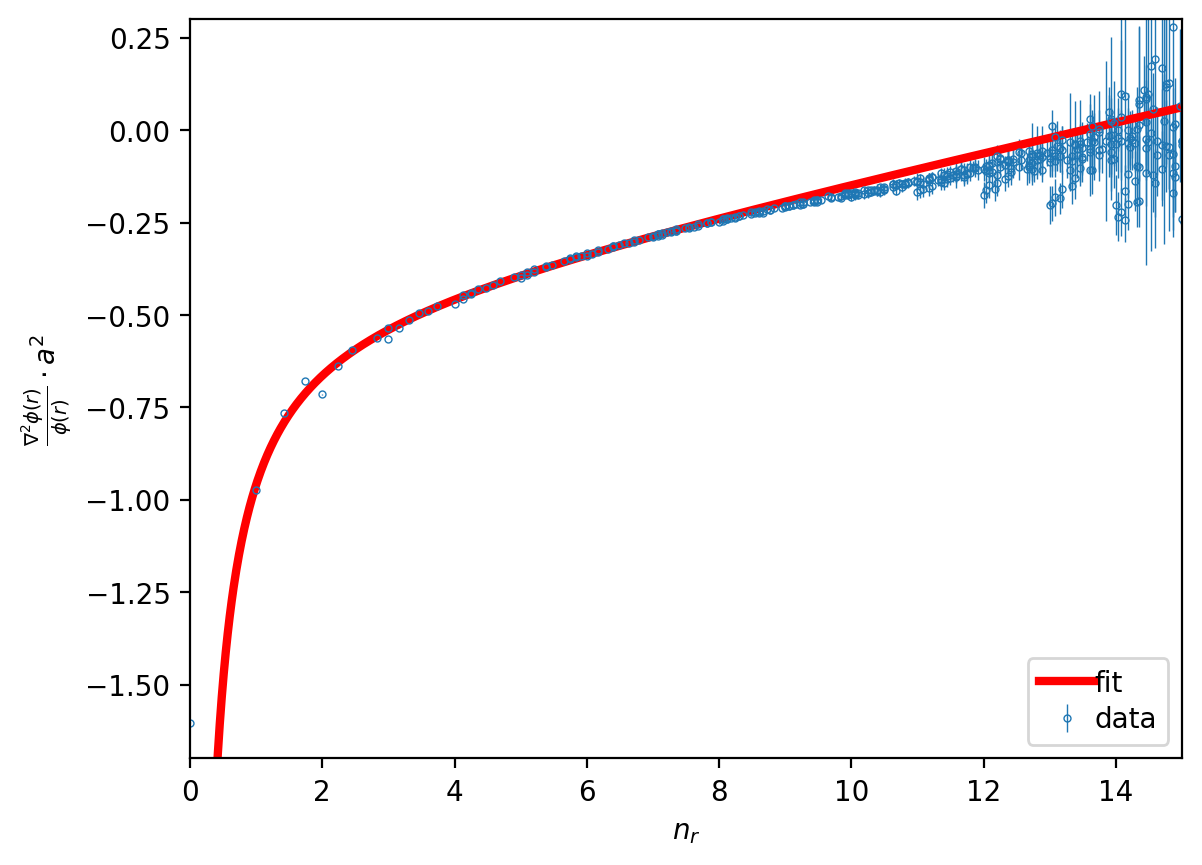

V0(r) = -0.5119453596307977/r + 0.038800581503396506r + -0.4860410637175886
sigma: 0.038800581503396506
sqrt sigma: 0.4284876184038687
String tension: 930.4389111190062 [MeV/fm]


In [42]:
# Initialize
ifname = f"result/{gauge[0]}/potential/sphr.v0.+29.txt"

rfit_min = 0.01
rfit_max = 12


# Define Cornell potential
def cornell(r, A, sigma, V0):
    return -A / r + sigma * r + V0


# Make data
rawdata = np.loadtxt(ifname, dtype=np.float64)[0:xyz_cube]

mask = (rawdata[:, 0] > rfit_min) & (rawdata[:, 0] < rfit_max)
subdata = rawdata[mask]
sorted_indices = np.argsort(subdata[:, 0])

fitdata = subdata[sorted_indices]

fitsites = fitdata[:, 0]
fitprev = fitdata[:, 1]
fiterr = fitdata[:, 2]

# Fit
para = {
    "A": 1,
    "sigma": 0.1,
    "V0": 0.01,
}
least_squares = LeastSquares(fitsites, fitprev, fiterr, cornell)
m = Minuit(least_squares, **para)
m.migrad()

# Print result
# df = np.shape(fitdata)[0] - 3 - 1
# chi = m.fval
# print(f"χ^2/df = {chi / df}")
fig, ax = plt.subplots()

errbar_plot_style = {
    "fmt": ".",
    "markersize": 5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "color": "tab:blue",
    # "markerfacecolor": "white",
    "fillstyle": "none",
}

plot_style = {
    "linewidth": 3,
    "color": "red",
}

legend_style = {
    "loc": 4,
    "handletextpad": 0,
    "labelspacing": 0.3,
}

ax.errorbar(
    rawdata[:, 0], rawdata[:, 1], rawdata[:, 2], label="data", **errbar_plot_style
)
x_fit = np.arange(0.01, 28, 0.01)
ax.plot(x_fit, cornell(x_fit, *m.values), label="fit", **plot_style)

ax.legend(**legend_style)

ax.set_xlabel(r"$n_r$")
ax.set_xlim(0, 15)

ax.set_ylabel(r"$\frac{\nabla^2\phi(r)}{\phi(r)}\cdot a^2$")
ax.set_ylim(-1.7, 0.3)

plt.plot()
plt.show()
plt.close()

print(f"V0(r) = -{m.values["A"]}/r + {m.values["sigma"]}r + {m.values["V0"]}")
print(f"sigma: {m.values["sigma"]}")
print(f"sqrt sigma: {m.values["sigma"] ** 0.5 * a_invrs}")
print(f"String tension: {m.values["sigma"] * a_invrs / a * 1000} [MeV/fm]")

### Figure

In [ ]:
potfig_root = "fig/pot"
for ig in range(2):
    if not os.path.exists(f"{potfig_root}/{gauge[ig]}"):
        os.makedirs(f"{potfig_root}/{gauge[ig]}")

#### Read data

In [ ]:
v0_c, vs_c, v0_l, vs_l = [[] for _ in range(4)]
for it in range(32):
    t = f"{it:+03}"
    v0_c.append(np.loadtxt(f"result/Coulomb/potential/sphr.v0.{t}.txt"))
    vs_c.append(np.loadtxt(f"result/Coulomb/potential/sphr.vs.{t}.txt"))
    v0_l.append(np.loadtxt(f"result/Landau/potential/sphr.v0.{t}.txt"))
    vs_l.append(np.loadtxt(f"result/Landau/potential/sphr.vs.{t}.txt"))

#### Seperate figures for each gauge

In [ ]:
ct = 29

plt.style.use(["science", "nature"])
# plt.style.use("default")
fig, ax = plt.subplots()

errbar_plot_style = {
    "fmt": ".",
    "color": "xkcd:primary blue",
    "markersize": 5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 4,
    "handletextpad": 0,
    "labelspacing": 0.3,
}

ax.errorbar(
    v0_c[ct][:, 0] * a,
    v0_c[ct][:, 1],
    v0_c[ct][:, 2],
    label=rf"Coulomb ($t/a={ct:02}$)",
    **errbar_plot_style,
)

ax.legend(**legend_style)

ax.set_xlabel(r"$r\ [{\rm fm}]$")
ax.set_xlim(0, 1.2)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.set_ylabel(r"$V_0(r)$ [GeV]")
ax.set_ylim(-1.7, 0.2)

plt.plot()
plt.show()
fig.savefig(f"{potfig_root}/{gauge[0]}/v0.+29.png", dpi=600)
plt.close()

In [ ]:
lt = 29

plt.style.use(["science", "nature"])
# plt.style.use("default")
fig, ax = plt.subplots()

errbar_plot_style = {
    "fmt": ".",
    "color": "xkcd:bright red",
    "markersize": 5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 4,
    "handletextpad": 0,
    "labelspacing": 0.3,
}

ax.errorbar(
    v0_l[lt][:, 0] * a,
    v0_l[lt][:, 1],
    v0_l[lt][:, 2],
    label=rf"Landau ($t/a={lt:02}$)",
    **errbar_plot_style,
)

ax.legend(**legend_style)

ax.set_xlabel(r"$r\ [{\rm fm}]$")
ax.set_xlim(0, 1.2)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.set_ylabel(r"$V_0(r)$ [GeV]")
ax.set_ylim(-1.7, 0.2)

plt.plot()
plt.show()
fig.savefig(f"{potfig_root}/{gauge[1]}/v0.+29.png", dpi=600)
plt.close()

#### Comparison between 2 gauges

$V_0$

In [ ]:
ct = 29
lt = 29

plt.style.use(["science", "nature"])
# plt.style.use("default")

fig, ax = plt.subplots()

errbar_plot_style = {
    "fmt": ".",
    "markersize": 5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 4,
    "handletextpad": 0,
    "labelspacing": 0.3,
    "fontsize": 11,
}

ax.errorbar(
    v0_c[ct][:, 0] * a,
    v0_c[ct][:, 1],
    v0_c[ct][:, 2],
    label=rf"Coulomb ($t/a={ct:02}$)",
    color="xkcd:primary blue",
    **errbar_plot_style,
)

ax.errorbar(
    v0_l[lt][:, 0] * a,
    v0_l[lt][:, 1],
    v0_l[lt][:, 2],
    label=rf"Landau ($t/a=${lt:02})",
    color="xkcd:bright red",
    **errbar_plot_style,
)

ax.legend(**legend_style)

ax.set_xlabel(r"$r\ [{\rm fm}]$")
ax.set_xlim(0, 1.2)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.set_ylabel(r"$V_0(r)$ [GeV]")
ax.set_ylim(-1.7, 0.3)

plt.plot()
plt.show()
fig.savefig(f"{potfig_root}/v0_CvsL.+29.png", dpi=600)
plt.close()

$V_0$ (shifted)

In [ ]:
fig, ax = plt.subplots()

ax.errorbar(
    v0_c[ct][:, 0] * a,
    v0_c[ct][:, 1],
    v0_c[ct][:, 2],
    label=rf"Coulomb ($t/a={ct:02}$)",
    color="xkcd:primary blue",
    **errbar_plot_style,
)

ax.errorbar(
    v0_l[lt][:, 0] * a,
    v0_l[lt][:, 1] - 0.355,
    v0_l[lt][:, 2],
    label=rf"Landau ($t/a=${lt:02})",
    color="xkcd:bright red",
    **errbar_plot_style,
)

ax.legend(**legend_style)

ax.set_xlabel(r"$r\ [{\rm fm}]$")
ax.set_xlim(0, 1.2)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.set_ylabel(r"$V_0(r)$ [GeV]")
ax.set_ylim(-1.7, 0.3)

plt.plot()
plt.show()
fig.savefig(f"{potfig_root}/v0_CvsL(shift).+29.png", dpi=600)
plt.close()

$V_s$

In [ ]:
ct = 29
lt = 29

plt.style.use(["science", "nature"])
# plt.style.use("default")

fig, ax = plt.subplots()

errbar_plot_style = {
    "fmt": ".",
    "markersize": 5,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "markerfacecolor": "white",
    # "fillstyle": "none",
}

legend_style = {
    "loc": 1,
    "handletextpad": 0,
    "labelspacing": 0.3,
    "fontsize": 11,
}

ax.errorbar(
    vs_c[ct][:, 0] * a,
    vs_c[ct][:, 1],
    vs_c[ct][:, 2],
    label=rf"Coulomb ($t/a={ct:02}$)",
    color="xkcd:primary blue",
    **errbar_plot_style,
)

ax.errorbar(
    vs_l[lt][:, 0] * a,
    vs_l[lt][:, 1],
    vs_l[lt][:, 2],
    label=rf"Landau ($t/a=${lt:02})",
    color="xkcd:bright red",
    **errbar_plot_style,
)

# Set grid (reserved)
ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.legend(**legend_style)

ax.set_xlabel(r"$r\ [{\rm fm}]$")
ax.set_xlim(-0.02, 0.6)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.set_ylabel(r"$V_0(r)$ [GeV]")
ax.set_ylim(-0.1, 1)

plt.plot()
plt.show()
fig.savefig(f"{potfig_root}/vs_CvsL.+29.png", dpi=600)
plt.close()